## 多个 feas_iti 且最后一趟列车 id 相同的乘客

|           |     rid | iti_id |    path_id | seg_id | train_id | board_ts | alight_ts |
| :-------- | ------: | -----: | ---------: | -----: | -------: | -------: | --------: |
| 93194730  | 1525794 |      2 | 1076103701 |      2 | 10301630 |    65071 |     65670 |
| 8610761   |  119014 |      6 | 1101102701 |      3 | 11002833 |    30045 |     30791 |
| 18578209  |  230428 |      6 | 1053108503 |      2 | 10401849 |    29715 |     30255 |
| 72855273  | 1321497 |      3 | 1110112802 |      1 | 10401844 |    60803 |     61537 |
| 105488240 | 1781873 |      2 | 1028106602 |      2 | 10401738 |    69396 |     69625 |
| 90908613  | 1485498 |      2 | 1023112302 |      2 | 10702370 |    64374 |     64780 |
| 91388272  | 1494286 |      1 | 1104111501 |      2 | 10702247 |    65070 |     65278 |
| 53621559  |  957712 |      6 | 1121102503 |      3 | 10401786 |    49174 |     50141 |
| 19767473  |  243641 |      1 | 1081103901 |      2 | 10702323 |    29509 |     31141 |
| 107978876 | 1880069 |      2 | 1129107002 |      1 | 10201226 |    73278 |     74154 |
| 106615427 | 1817923 |      1 | 1027110801 |      2 | 10301362 |    71471 |     73514 |
| 76737269  | 1359494 |      1 | 1099102101 |      2 | 10301421 |    64071 |     65266 |
| 100422001 | 1661221 |      5 | 1061108702 |      1 | 10100270 |    66558 |     66886 |
| 2408620   |   41409 |      2 | 1111106502 |      1 | 10401886 |    25727 |     25836 |
| 101105912 | 1675451 |      1 | 1110101301 |      1 | 10401914 |    66944 |     67031 |
| 92513072  | 1514419 |      3 | 1097110302 |      3 | 10200839 |    65302 |     65408 |
| 81121188  | 1412555 |      1 | 1061109504 |      2 | 10201199 |    63371 |     63480 |
| 108069499 | 1886032 |      1 | 1032108201 |      1 | 10200950 |    73568 |     75192 |
| 73737366  | 1331466 |      1 | 1086110901 |      2 | 10702414 |    61616 |     62107 |
| 48046191  |  811513 |      3 | 1076103602 |      3 | 10301265 |    42747 |     43084 |


# 多个 feas_iti 且所有 egress time 都超过 500 秒的乘客

## 这些 rid 大多数并不是因为有很多 feas_iti，而是少数的 feas_iti 但 egress time 都非常久(超过500s)。

- 人数虽然少，但是是否需要考虑加入额外判断条件，或者重新算呢？


```python
# df[df["dis_penaled_sum"] == 0].index.get_level_values(0).unique()  # 939 rids does not have even one actually feasible itinerary.

rids_no_prob = np.array([    983,    1171,    1376,    1730,    1750,    2408,    3173, 3190,    3326,    3368,    3520,    3696,    5662,    6193, 13409,   78714,  109114,  114135,  142032,  151271,  152006, 152948,  171518,  188488,  263229,  341170,  444924,  461597, 466642,  497716,  497937,  513497,  515713,  518382,  531630, 533623,  536615,  545734,  554578,  570520,  572792,  575241, 582118,  585940,  595735,  600747,  607498,  610731,  622531, 628065,  635754,  637178,  639015,  640134,  653988,  654257, 654906,  655749,  656910,  665534,  666669,  667648,  669695, 672009,  678702,  678727,  678973,  683550,  688339,  692266, 693098,  693734,  694574,  696115,  697564,  700227,  700251, 702537,  706707,  708138,  709379,  709446,  709469,  709503, 709718,  709990,  710044,  710433,  711066,  711229,  713606, 713822,  714055,  714615,  715264,  721473,  722488,  723693, 727205,  727394,  727526,  727603,  730476,  730664,  730699, 732154,  732277,  733679,  733867,  733972,  737426,  737866, 739558,  740359,  740910,  741115,  741545,  743840,  745024, 745959,  746448,  750489,  750567,  751511,  755274,  757671, 757778,  758022,  758190,  760528,  760529,  762483,  763950, 764342,  764365,  764366,  764505,  764538,  766153,  766461, 767282,  768051,  768412,  769393,  769418,  773988,  774668, 775309,  775344,  775426,  776184,  776376,  776429,  778887, 778991,  779162,  780317,  780683,  780684,  780790,  781115, 782281,  782504,  783118,  783517,  783550,  784769,  785333, 786826,  788783,  791004,  791110,  791297,  791499,  791522, 791968,  792173,  792331,  794180,  795385,  796571,  803742, 803989,  803999,  805529,  806375,  807357,  807634,  810828, 811192,  812630,  813416,  814146,  814839,  815426,  817941, 817973,  819476,  820863,  820939,  821170,  821236,  822471, 824767,  825960,  828010,  830984,  834778,  837965,  838610, 843128,  843369,  844196,  846048,  847068,  848018,  849540, 850737,  850840,  851337,  852233,  853899,  854016,  856442, 858616,  858641,  859334,  860631,  862528,  863742,  864060, 864772,  864809,  866326,  868891,  868941,  870472,  872163, 873292,  874160,  874242,  874298,  874954,  875175,  875273, 877528,  877635,  878154,  878216,  880749,  881054,  881464, 885455,  886271,  886831,  887040,  888861,  889509,  890886, 892722,  897173,  899148,  899500,  899609,  899801,  901251, 901764,  903630,  905947,  906616,  906622,  909565,  910529, 910595,  911650,  911966,  913001,  913843,  914592,  915037, 915051,  916066,  916450,  917474,  920364,  920404,  922309, 923975,  925244,  925833,  925859,  926228,  926532,  927058, 927445,  927943,  930118,  930979,  931445,  931731,  932182, 933117,  933600,  936806,  938871,  939755,  941348,  942323, 942381,  942506,  944315,  944363,  945313,  946393,  947708, 948205,  948267,  948608,  949764,  952301,  954201,  955072, 955370,  955372,  956005,  956153,  958167,  958691,  959970, 959971,  961263,  961463,  964296,  965028,  965088,  967417, 967487,  968317,  971273,  971921,  975384,  976226,  982008, 983149,  984655,  986253,  986607,  986781,  988043,  997063, 1001197, 1001285, 1003339, 1003446, 1004783, 1004838, 1005324, 1005374, 1007284, 1007485, 1014431, 1016511, 1018888, 1018964, 1019416, 1020046, 1020743, 1021476, 1022328, 1022486, 1023761, 1023860, 1023979, 1030413, 1031973, 1033517, 1034492, 1036125, 1037384, 1040733, 1042371, 1043472, 1044085, 1044202, 1044291, 1045229, 1048708, 1049726, 1051170, 1053487, 1057018, 1057219, 1059664, 1061891, 1064548, 1065705, 1066358, 1067866, 1069420, 1069952, 1070069, 1070448, 1074539, 1074596, 1075089, 1075091, 1079635, 1082442, 1082443, 1082468, 1085943, 1090688, 1095858, 1096864, 1097857, 1098180, 1098651, 1100119, 1102165, 1102657, 1107163, 1107785, 1108039, 1108332, 1109364, 1109664, 1109773, 1110420, 1114588, 1114922, 1115342, 1115348, 1118188, 1118280, 1118604, 1118718, 1121972, 1122524, 1124631, 1125280, 1125459, 1127016, 1127169, 1127286, 1127400, 1128714, 1129690, 1130016, 1130579, 1133014, 1134730, 1135438, 1136176, 1137428, 1137613, 1137903, 1139091, 1139141, 1139305, 1144079, 1145028, 1145042, 1145409, 1145419, 1145997, 1150115, 1150495, 1151557, 1152825, 1153655, 1153884, 1153906, 1155251, 1155564, 1156079, 1156242, 1156640, 1156666, 1156755, 1157249, 1157449, 1157470, 1157618, 1157620, 1157738, 1157774, 1158112, 1159197, 1159259, 1160072, 1160073, 1160075, 1160175, 1160282, 1160394, 1160501, 1161143, 1161796, 1161823, 1162518, 1162880, 1163672, 1163729, 1163932, 1165198, 1165542, 1165665, 1165882, 1166172, 1166470, 1167342, 1167606, 1167713, 1167910, 1168150, 1168208, 1168310, 1173677, 1174001, 1175631, 1176498, 1176949, 1177887, 1179012, 1179477, 1179533, 1179621, 1179678, 1179679, 1180029, 1180653, 1180829, 1181155, 1183296, 1183966, 1184256, 1184401, 1184447, 1184448, 1184453, 1184485, 1184489, 1184912, 1185052, 1185457, 1187113, 1187216, 1187849, 1187872, 1190861, 1191348, 1191696, 1191867, 1194461, 1194542, 1194969, 1198122, 1200746, 1201364, 1202277, 1202302, 1203348, 1204064, 1207757, 1208141, 1209542, 1209958, 1211352, 1211605, 1212250, 1212554, 1212670, 1213024, 1214333, 1214714, 1214759, 1215304, 1216089, 1216582, 1216852, 1217958, 1217998, 1218288, 1218561, 1219473, 1219756, 1219973, 1220140, 1221687, 1222681, 1223990, 1225038, 1226358, 1229332, 1230196, 1230453, 1230501, 1231881, 1231886, 1231948, 1232608, 1233054, 1233175, 1233176, 1234219, 1234329, 1235033, 1235663, 1235789, 1237437, 1237554, 1237558, 1237618, 1238290, 1238515, 1239673, 1240375, 1240379, 1240413, 1242830, 1243972, 1246267, 1247336, 1247570, 1247658, 1250095, 1252320, 1254915, 1260456, 1261453, 1261822, 1264966, 1269860, 1275013, 1277077, 1277133, 1277863, 1278772, 1282235, 1282912, 1283556, 1289346, 1290744, 1292698, 1293113, 1294485, 1298868, 1307022, 1315972, 1316176, 1333875, 1337063, 1342161, 1346181, 1365269, 1372539, 1388395, 1394467, 1395326, 1400108, 1402350, 1403223, 1420719, 1420922, 1421636, 1432462, 1470619, 1490095, 1493014, 1500443, 1501142, 1524084, 1524968, 1530056, 1563164, 1563282, 1597515, 1603743, 1604629, 1614501, 1614681, 1616287, 1627029, 1628700, 1641135, 1650424, 1651627, 1653764, 1697491, 1697625, 1705830, 1716626, 1716627, 1717967, 1721374, 1721958, 1722470, 1727185, 1741929, 1746496, 1754788, 1764930, 1768074, 1770384, 1770956, 1778173, 1783386, 1785381, 1789429, 1794616, 1796538, 1797009, 1798571, 1803994, 1806271, 1808904, 1813908, 1815795, 1820131, 1823125, 1824979, 1825081, 1827445, 1828507, 1832774, 1840495, 1843441, 1850352, 1850402, 1850496, 1851571, 1853832, 1853866, 1858590, 1860748, 1861981, 1862981, 1863258, 1863375, 1863565, 1865043, 1865876, 1869305, 1869645, 1870054, 1873715, 1874121, 1875199, 1876336, 1877523, 1880660, 1881330, 1882253, 1882870, 1884488, 1885913, 1886445, 1887226, 1888704, 1889001, 1890360, 1891444, 1895705, 1895768, 1898139, 1899027, 1900315, 1902154, 1902868, 1902929, 1903269, 1907134, 1907158, 1909720, 1911432, 1914675, 1916131, 1916383, 1918556, 1920398, 1920858, 1921681, 1923222, 1923631, 1923897, 1923951, 1924212, 1924387, 1925521, 1925777, 1927235, 1928390, 1929579, 1930042, 1930120, 1930478, 1930520, 1930753, 1932350, 1932484, 1932881, 1932922, 1933149, 1933651, 1933764, 1935135, 1936290, 1936969, 1938419, 1938428, 1942445, 1942948, 1943065, 1943206, 1944138, 1947804, 1948119, 1948547, 1949064, 1949111, 1949609, 1949747, 1951243, 1951282, 1954409, 1955348, 1955586, 1955636, 1955977, 1957367, 1957429, 1957495, 1957727, 1958150, 1958581, 1960169, 1960784, 1961741, 1962316, 1962332, 1963384, 1963635, 1964996, 1965016, 1968970, 1969000, 1969399, 1970514, 1970544, 1970629, 1971445, 1972297, 1975064, 1975221, 1976052, 1976394, 1979076, 1979078, 1979289, 1979379, 1982060, 1982061, 1983936, 1985250, 1985876, 1986766, 1988936, 1990452, 1991267, 1991274, 1992537, 1992648, 1993278, 1993697, 1994224, 1996181, 1996691, 1997959, 1998291, 1998371, 1999302, 1999846, 2000179, 2000900, 2001267, 2001414, 2002134, 2002350, 2003072, 2003483, 2004339, 2006220, 2007268, 2010078, 2012005, 2012043, 2013005, 2014150, 2014187, 2014231, 2014282, 2014601, 2018049, 2018118, 2018121, 2020239, 2020425, 2020453, 2020474, 2020531, 2020688, 2020690, 2020808, 2022248, 2026008, 2032115, 2032116, 2033915, 2034471, 2034482, 2034497, 2034504, 2034577, 2034751, 2036026, 2037322, 2038318, 2038421, 2039455, 2041306, 2041577, 2042050, 2042344, 2042481, 2042625, 2042634, 2043962, 2043963, 2045101])

# check feasible itineraries of those rids
import numpy as np
from src import config
from src.passenger import _plot_check_feas_iti

config.load_config()

rid = np.random.choice(rids_no_prob, 1)[0]
_plot_check_feas_iti(rid=rid, print_on=True)
```


In [ ]:
from src import config
from src.utils import *
from src.globals import get_etd, get_ttd
from src.itinerary import attach_walk_dis_all, cal_in_vehicle_penal_all
from src.walk_time_dis_calculator import WalkTimeDisModel

config.load_config()

wtd = WalkTimeDisModel(get_etd(), get_ttd())
left = read_(config.CONFIG["results"]["left"], show_timer=False)

dis = attach_walk_dis_all(wtd=wtd, left=left)
dis

[INFO] Reading file: results\egress\etd_1.csv
[INFO] Reading file: results\transfer\ttd_1.csv
[INFO] Reading file: results\network\pathvia.pkl
[INFO] Reading file: results\network\platform.csv
[INFO] Reading file: results\trajectory\left.pkl
[INFO] Calculating entry walk distribution for all itineraries...
[INFO] Reading file: data\AFC.pkl
[INFO] Calculating egress walk distribution for all itineraries...
[INFO] Calculating transfer walk distribution for all itineraries...


,rid,iti_id,path_id,seg_id,t1,t2,pp_id1,pp_id2,time,dis
0,285,14,1120101002,1,21238,23410,103801,103802,2172,1.000000e+00
1,285,14,1120101002,2,24412,27272,102201,102202,2860,1.000000e+00
2,285,15,1120101002,1,21238,23410,103801,103802,2172,1.000000e+00
3,285,15,1120101002,2,24412,24520,102201,102202,108,1.785901e-01
4,285,16,1120101002,1,21238,23410,103801,103802,2172,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
62976911,2046865,2,1097101501,-1,85823,85947,0,101501,124,2.987034e-01
62976912,2046868,1,1097101501,-1,85481,85940,0,101501,459,7.257833e-99
62976913,2046868,2,1097101501,-1,85823,85940,0,101501,117,3.588177e-01
62976914,2046883,1,1129101001,-1,85741,85887,0,101002,146,8.579250e-01


In [4]:
# penal = cal_penal_all(penal_df=pd.DataFrame(), left=left)
penal = left.copy()
penal["penalty"] = 1.0
penal

,rid,iti_id,path_id,seg_id,train_id,board_ts,alight_ts,penalty
2,285,1,1120101001,1,10702170,21132,22747,1.0
3,285,2,1120101001,1,10702170,25273,26962,1.0
4,285,3,1120101001,1,10702186,21797,23422,1.0
5,285,4,1120101001,1,10702186,25949,27655,1.0
6,285,5,1120101001,1,10702207,22652,24277,1.0
...,...,...,...,...,...,...,...,...
109949952,2046865,2,1097101501,1,10100645,85287,85823,1.0
109949955,2046868,1,1097101501,1,10100421,84945,85481,1.0
109949956,2046868,2,1097101501,1,10100645,85287,85823,1.0
109949965,2046883,1,1129101001,1,10702289,85531,85741,1.0


In [ ]:
from src.itinerary import compute_itinerary_probabilities
df = compute_itinerary_probabilities(dis_attached_iti=dis, penal=penal)  # 
df

dis  penalty    dis_penaled  dis_penaled_sum  \
rid     iti_id                                                           
285     1        1.398369e-98      1.0   1.398369e-98         8.820042   
        2        1.398369e-98      1.0   1.398369e-98         8.820042   
        3        1.398369e-98      1.0   1.398369e-98         8.820042   
        4        9.970899e-01      1.0   9.970899e-01         8.820042   
        5        1.398369e-98      1.0   1.398369e-98         8.820042   
...                       ...      ...            ...              ...   
2046865 2        2.987034e-01      1.0   2.987034e-01         0.298703   
2046868 1       1.943704e-101      1.0  1.943704e-101         0.358818   
        2        3.588177e-01      1.0   3.588177e-01         0.358818   
2046883 1        8.579250e-01      1.0   8.579250e-01         0.857925   
        2       2.105958e-101      1.0  2.105958e-101         0.857925   

                         prob  
rid     iti_id                 
285     1        1.585445e-99  
        2        1.585445e-99  
        3        1.585445e-99  
        4        1.130482e-01  
        5        1.585445e-99  
...                       ...  
2046865 2        1.000000e+00  
2046868 1       5.416968e-101  
        2        1.000000e+00  
2046883 1        1.000000e+00  
        2       2.454711e-101  

[16339032 rows x 5 columns]

In [ ]:
# 没有进行epsilon处理egress pdf时的output为：((186331, 5), (364689, 5), (3401937, 5), (16339032, 5))
# 进行epsilon处理后：((185868, 5), (364410, 5), (0, 5), (16339032, 5))
# 表示prob不可能为0了。
df[df['prob'] == 1].shape, df[df['prob'] > 0.99].shape, df[(df['prob'] == 0)].shape, df.shape

((185868, 5), (364410, 5), (0, 5), (16339032, 5))

# plot timetable


In [4]:
tt = read_("TT", drop_cols=False)
tt[(tt["LINE_NID"] == 2) & (tt["DEPARTURE_TS"] < 5.5*3600+600) & ((tt["DEPARTURE_TS"] > 5.5*3600))]

[INFO] read_(('TT',), {'drop_cols': False}) executing at 05-04 15:19:49.
[INFO] Reading file: data\TT.pkl
[INFO] read_(('TT',), {'drop_cols': False}) executed in  05-04 15:19:49. (05-04 15:19:49 -> 0.1026s )


,TRAIN_ID_old,TRAIN_NUMBER,STATION_NID,STATION_NAME,O_STATION,T_STATION,ARRIVE_TIME,DEPARTURE_TIME,STOP_TIME,ARRIVE_TS,DEPARTURE_TS,UPDOWN,LINE_NID,STATION_UID,DWELL_TIME
TRAIN_ID,,,,,,,,,,,,,,,
10200746,10200746,1041102,10246,成都行政学院,成都市行政学院,龙泉驿,2018-04-11 05:33:32,2018-04-11 05:34:22,50,20012,20062,1,2,1106,50
10200746,10200746,1041102,10247,大面铺,成都市行政学院,龙泉驿,2018-04-11 05:37:33,2018-04-11 05:38:08,35,20253,20288,1,2,1083,35
10200756,10200756,1050202,10221,犀浦,犀浦,龙泉驿,2018-04-11 05:36:09,2018-04-11 05:36:59,50,20169,20219,1,2,1101,50
10200756,10200756,1050202,10222,天河路,犀浦,龙泉驿,2018-04-11 05:38:55,2018-04-11 05:39:30,35,20335,20370,1,2,1030,35


In [13]:
# tt.loc[10200746]
# tt.groupby(tt.index)["STATION_NID"].count().sort_values()
tt.loc[10702289]

,TRAIN_ID_old,TRAIN_NUMBER,STATION_NID,STATION_NAME,O_STATION,T_STATION,ARRIVE_TIME,DEPARTURE_TIME,STOP_TIME,ARRIVE_TS,DEPARTURE_TS,UPDOWN,LINE_NID,STATION_UID,DWELL_TIME
TRAIN_ID,,,,,,,,,,,,,,,
10702289,10702289,11107104,10729,槐树店站,槐树店站,崔家店站一,2018-04-11 05:48:45,2018-04-11 05:52:15,30,20925,21135,-1,7,1010,210
10702289,10702289,11107104,10728,双店路站,槐树店站,崔家店站一,2018-04-11 05:53:31,2018-04-11 05:54:01,30,21211,21241,-1,7,1072,30
10702289,10702289,11107104,10727,崔家店,槐树店站,崔家店站一,2018-04-11 05:55:18,2018-04-11 05:55:48,30,21318,21348,-1,7,1012,30
10702289,10702290,11107106,10726,理工大学站,崔家店站二,崔家店站一,2018-04-11 05:57:13,2018-04-11 05:57:48,35,21433,21468,-1,7,1134,35
10702289,10702290,11107106,10725,二仙桥站,崔家店站二,崔家店站一,2018-04-11 05:59:13,2018-04-11 05:59:48,35,21553,21588,-1,7,1057,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10702289,10702305,11107136,10731,成都东客站,崔家店站二,崔家店站一,2018-04-11 23:44:51,2018-04-11 23:45:31,40,85491,85531,-1,7,1129,40
10702289,10702305,11107136,10730,迎晖路站,崔家店站二,崔家店站一,2018-04-11 23:46:51,2018-04-11 23:47:25,34,85611,85645,-1,7,1093,34
10702289,10702305,11107136,10729,槐树店站,崔家店站二,崔家店站一,2018-04-11 23:49:01,2018-04-11 23:49:51,50,85741,85791,-1,7,1010,50


In [61]:
from src.timetable import calculate_train_load_profile


assigned = read_all("assigned")
board_records = assigned[assigned["train_id"]
                         == 10200746][["board_ts", "alight_ts"]].values
load_data = calculate_train_load_profile(
    train_id=10200746, board_records=board_records)
load_data

[INFO] read_all(('assigned',), {}) executing at 05-03 21:30:15.
[INFO] Reading 1 versioned files: results\trajectory\assigned.pkl
[INFO] read_all(('assigned',), {}) executed in  05-03 21:30:15. (05-03 21:30:15 -> 0.0075s )


array([[10246, 20062, 10247, 20253,     0],
       [10247, 20288, 10248, 20379,     0],
       [10248, 20414, 10249, 20509,     0],
       [10249, 20544, 10250, 20667,     0],
       [10250, 20702, 10251, 20829,     0],
       [10251, 20864, 10252, 85357,     0]], dtype=int64)

In [68]:
tt[(tt["DEPARTURE_TS"] - tt["STOP_TIME"] != tt["ARRIVE_TS"]) & (tt['DWELL_TIME'] > 300)]

,STATION_NID,STOP_TIME,ARRIVE_TS,DEPARTURE_TS,UPDOWN,LINE_NID,STATION_UID,DWELL_TIME
TRAIN_ID,,,,,,,,
10200746,10252,53,20977,85410,1,2,1085,64433
10200747,10252,53,20977,85410,-1,2,1085,64433
10100421,10154,25,81583,81908,-1,1,1078,325
10100709,10141,1,20329,20630,1,1,1043,301
10100710,10141,1,20329,20630,-1,1,1043,301
10702207,10729,45,19961,20306,-1,7,1010,345
10301424,10321,30,24635,24965,1,3,1108,330
10702512,10727,1,75190,75551,-1,7,1012,361


# build penalty df test

In [ ]:
import pandas as pd
from src import config
config.load_config()

from src.utils import read_, read_all
from src.globals import get_etd, get_ttd
from src.walk_time_dis_calculator import WalkTimeDisModel
from src.itinerary import attach_walk_dis_all, cal_in_vehicle_penal_all

wtd = WalkTimeDisModel(get_etd(), get_ttd())
left = read_(config.CONFIG["results"]["left"], show_timer=False)
left

[INFO] Reading file: results\trajectory\left.pkl


,rid,iti_id,path_id,seg_id,train_id,board_ts,alight_ts
2,285,1,1120101001,1,10702170,21132,22747
3,285,2,1120101001,1,10702170,25273,26962
4,285,3,1120101001,1,10702186,21797,23422
5,285,4,1120101001,1,10702186,25949,27655
6,285,5,1120101001,1,10702207,22652,24277
...,...,...,...,...,...,...,...
109949952,2046865,2,1097101501,1,10100645,85287,85823
109949955,2046868,1,1097101501,1,10100421,84945,85481
109949956,2046868,2,1097101501,1,10100645,85287,85823
109949965,2046883,1,1129101001,1,10702289,85531,85741


In [ ]:
from src.timetable import find_overload_train_section, get_ti2c, reset_ti2c
from src.congest_penal import build_penal_mapper_df, _build_penalty_dict_array

import matplotlib.pyplot as plt

# reset TI2C
reset_ti2c()
config.CONFIG["parameters"]["TRAIN_A_AREA"] = 52
config.CONFIG["parameters"]["TRAIN_B_AREA"] = 52
get_ti2c()
print("capacities: ", [i for i in get_ti2c().values()][0])

overload_train_section = find_overload_train_section(read_all("assigned", show_timer=False))
overload_train_section

[INFO] Reading file: data\TT.pkl
capacities:  (581.64, 679.4)
[INFO] Reading 1 versioned files: results\trajectory\assigned.pkl
[WARNING] Train 10100135 exceeds max capacity!


{10200732: array([[10247, 29110, 10246, 29301,   606],
        [10246, 29351, 10245, 29460,   630],
        [10245, 29497, 10244, 29582,   657],
        [10244, 29617, 10243, 29727,   662],
        [10243, 29765, 10242, 29844,   669],
        [10241, 30038, 10240, 30121,   646],
        [10240, 30156, 10239, 30222,   658],
        [10239, 30259, 10238, 30366,   627],
        [10238, 30404, 10237, 30479,   587]], dtype=int64),
 10200956: array([[10241, 29678, 10240, 29761,   605],
        [10240, 29796, 10239, 29862,   622],
        [10239, 29899, 10238, 30006,   620]], dtype=int64),
 10200799: array([[10244, 30517, 10243, 30627,   591],
        [10243, 30665, 10242, 30744,   601],
        [10241, 30938, 10240, 31021,   610],
        [10240, 31056, 10239, 31122,   619],
        [10239, 31159, 10238, 31266,   611]], dtype=int64),
 10100135: array([[10144, 29989, 10141, 30091,   790],
        [10141, 30141, 10140, 30258,   817],
        [10140, 30293, 10139, 30387,   825],
        [10139,

In [ ]:
import numpy as np
penal_debug = _build_penalty_dict_array(overload_train_section=overload_train_section, penal_func_type="x")
np.set_printoptions(precision=4, suppress=True, linewidth=180)
print(penal_debug)
df_pn1 = build_penal_mapper_df(overload_train_section=overload_train_section, penal_func_type="x", penal_agg_method="min", )
df_pn1

{(10200732, 29110, 29301): array([[10247.    , 29110.    , 10246.    , 29301.    ,   606.    ,     0.7508]]), (10200732, 29110, 29460): array([[10247.    , 29110.    , 10246.    , 29301.    ,   606.    ,     0.7508],
       [10246.    , 29351.    , 10245.    , 29460.    ,   630.    ,     0.5053]]), (10200732, 29110, 29582): array([[10247.    , 29110.    , 10246.    , 29301.    ,   606.    ,     0.7508],
       [10246.    , 29351.    , 10245.    , 29460.    ,   630.    ,     0.5053],
       [10245.    , 29497.    , 10244.    , 29582.    ,   657.    ,     0.2291]]), (10200732, 29110, 29727): array([[10247.    , 29110.    , 10246.    , 29301.    ,   606.    ,     0.7508],
       [10246.    , 29351.    , 10245.    , 29460.    ,   630.    ,     0.5053],
       [10245.    , 29497.    , 10244.    , 29582.    ,   657.    ,     0.2291],
       [10244.    , 29617.    , 10243.    , 29727.    ,   662.    ,     0.178 ]]), (10200732, 29110, 29844): array([[10247.    , 29110.    , 10246.    , 29301. 

,train_id,board_ts,alight_ts,penalty
0,10200732,29110,29301,0.750818
1,10200732,29110,29460,0.505319
2,10200732,29110,29582,0.229133
3,10200732,29110,29727,0.177987
4,10200732,29110,29844,0.106383
...,...,...,...,...
502,10100095,66956,68317,0.986088
503,10100095,66956,68442,0.986088
504,10100095,66956,68557,0.986088
505,10100095,66956,68704,0.986088


   train_id  board_ts  alight_ts  penal_min  penal_prod  penal_mean
0  10200732     29110      29301   0.750818    0.750818    0.750818
1  10200732     29110      29460   0.505319    0.379403    0.628069
2  10200732     29110      29582   0.229133    0.086934    0.495090
3  10200732     29110      29727   0.177987    0.015473    0.415814
4  10200732     29110      29844   0.106383    0.001646    0.353928


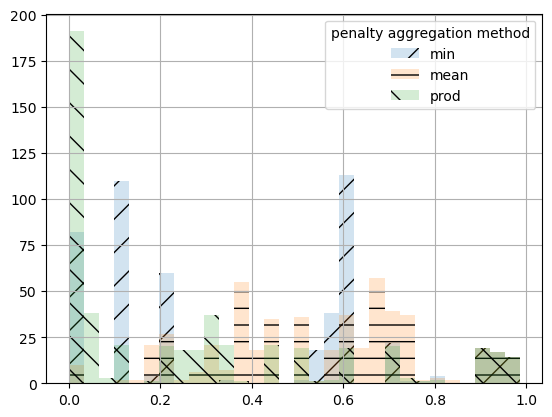

In [ ]:
df_pn1 = build_penal_mapper_df(overload_train_section=overload_train_section, penal_func_type="x", penal_agg_method="min", )
df_pn2 = build_penal_mapper_df(overload_train_section=overload_train_section, penal_func_type="x", penal_agg_method="prod", )
df_pn3 = build_penal_mapper_df(overload_train_section=overload_train_section, penal_func_type="x", penal_agg_method="mean", )

df = pd.concat([df_pn1, df_pn2.iloc[:, -1], df_pn3.iloc[:, -1]], axis=1)
df.columns=["train_id", "board_ts", "alight_ts", "penal_min", "penal_prod", "penal_mean"]
print(df.head())
df["penal_min"].hist( bins=30, label="min" , alpha=0.2, hatch="/")
df["penal_mean"].hist(bins=30, label="mean", alpha=0.2, hatch="-")
df["penal_prod"].hist(bins=30, label="prod", alpha=0.2, hatch="\\")
plt.legend(title="penalty aggregation method")

In [ ]:
dis = attach_walk_dis_all(wtd=wtd, left=left)  # takes 35s to run
dis

[INFO] Calculating entry walk distribution for all itineraries...
[INFO] Reading file: data\AFC.pkl
[INFO] Calculating egress walk distribution for all itineraries...
[INFO] Calculating transfer walk distribution for all itineraries...


,rid,iti_id,path_id,seg_id,t1,t2,pp_id1,pp_id2,time,dis
0,285,14,1120101002,1,21238,23410,103801,103802,2172,1.000000
1,285,14,1120101002,2,24412,27272,102201,102202,2860,1.000000
2,285,15,1120101002,1,21238,23410,103801,103802,2172,1.000000
3,285,15,1120101002,2,24412,24520,102201,102202,108,0.178590
4,285,16,1120101002,1,21238,23410,103801,103802,2172,1.000000
...,...,...,...,...,...,...,...,...,...,...
62976911,2046865,2,1097101501,-1,85823,85947,0,101501,124,0.298703
62976912,2046868,1,1097101501,-1,85481,85940,0,101501,459,0.000000
62976913,2046868,2,1097101501,-1,85823,85940,0,101501,117,0.358818
62976914,2046883,1,1129101001,-1,85741,85887,0,101002,146,0.857925


In [ ]:
# penal = cal_penal_all(penal_df=df_pn1, left=left)  # aggregate penalty with "min"
# penal = cal_penal_all(penal_df=df_pn2, left=left)  # aggregate penalty with "prod"
penal = cal_in_vehicle_penal_all(penal_mapper_df=df_pn3, left=left)  # aggregate penalty with "mean"
penal

,rid,iti_id,path_id,seg_id,train_id,board_ts,alight_ts,penalty
0,285,1,1120101001,1,10702170,21132,22747,1.0
1,285,2,1120101001,1,10702170,25273,26962,1.0
2,285,3,1120101001,1,10702186,21797,23422,1.0
3,285,4,1120101001,1,10702186,25949,27655,1.0
4,285,5,1120101001,1,10702207,22652,24277,1.0
...,...,...,...,...,...,...,...,...
46637879,2046865,2,1097101501,1,10100645,85287,85823,1.0
46637880,2046868,1,1097101501,1,10100421,84945,85481,1.0
46637881,2046868,2,1097101501,1,10100645,85287,85823,1.0
46637882,2046883,1,1129101001,1,10702289,85531,85741,1.0


In [ ]:
prob = compute_itinerary_probabilities(dis_attached_iti=dis, penalized_iti=penal)
prob

dis  penalty    dis_penaled  dis_penaled_sum  \
rid     iti_id                                                           
285     1        1.398369e-98      1.0   1.398369e-98         8.820042   
        2        1.398369e-98      1.0   1.398369e-98         8.820042   
        3        1.398369e-98      1.0   1.398369e-98         8.820042   
        4        9.970899e-01      1.0   9.970899e-01         8.820042   
        5        1.398369e-98      1.0   1.398369e-98         8.820042   
...                       ...      ...            ...              ...   
2046865 2        2.987034e-01      1.0   2.987034e-01         0.298703   
2046868 1       1.943704e-101      1.0  1.943704e-101         0.358818   
        2        3.588177e-01      1.0   3.588177e-01         0.358818   
2046883 1        8.579250e-01      1.0   8.579250e-01         0.857925   
        2       2.105958e-101      1.0  2.105958e-101         0.857925   

                         prob  
rid     iti_id                 
285     1        1.585445e-99  
        2        1.585445e-99  
        3        1.585445e-99  
        4        1.130482e-01  
        5        1.585445e-99  
...                       ...  
2046865 2        1.000000e+00  
2046868 1       5.416968e-101  
        2        1.000000e+00  
2046883 1        1.000000e+00  
        2       2.454711e-101  

[16339032 rows x 5 columns]

In [29]:
# 受影响的乘客
rids_affected = prob[prob["penalty"] != 1].index.get_level_values(0).unique()
rids_affected

Index([   7329,    9562,   39387,   56992,   60270,   60336,   67143,   81821,
         82848,   82984,
       ...
       1682069, 1682970, 1683229, 1683832, 1684434, 1684623, 1684687, 1685064,
       1685067, 1685886],
      dtype='int32', name='rid', length=9096)

In [34]:
df = prob[prob.index.get_level_values(0).isin(rids_affected)].copy()
df['dis_sum'] = df.groupby(level=[0])["dis"].transform("sum")
df['prob_without_penalty'] = df['dis'] / df['dis_sum']
df

dis   penalty   dis_penaled  dis_penaled_sum  \
rid     iti_id                                                          
7329    1       1.032863e-98  1.000000  1.032863e-98         0.208868   
        2       1.032863e-98  0.254705  2.630757e-99         0.208868   
        3       1.032863e-98  1.000000  1.032863e-98         0.208868   
        4       2.088677e-01  1.000000  2.088677e-01         0.208868   
        5       1.032863e-98  1.000000  1.032863e-98         0.208868   
...                      ...       ...           ...              ...   
1685067 1       1.672319e-99  0.986088  1.649055e-99         0.614571   
        2       6.145706e-01  1.000000  6.145706e-01         0.614571   
        3       1.406611e-07  1.000000  1.406611e-07         0.614571   
1685886 1       3.374088e-01  1.000000  3.374088e-01         0.337409   
        2       1.119151e-24  0.986088  1.103581e-24         0.337409   

                        prob   dis_sum  prob_without_penalty  
rid     iti_id                                                
7329    1       4.945058e-98  0.208868          4.945058e-98  
        2       1.259533e-98  0.208868          4.945058e-98  
        3       4.945058e-98  0.208868          4.945058e-98  
        4       1.000000e+00  0.208868          1.000000e+00  
        5       4.945058e-98  0.208868          4.945058e-98  
...                      ...       ...                   ...  
1685067 1       2.683263e-99  0.614571          2.721118e-99  
        2       9.999998e-01  0.614571          9.999998e-01  
        3       2.288769e-07  0.614571          2.288769e-07  
1685886 1       1.000000e+00  0.337409          1.000000e+00  
        2       3.270755e-24  0.337409          3.316899e-24  

[277390 rows x 7 columns]

<Axes: >

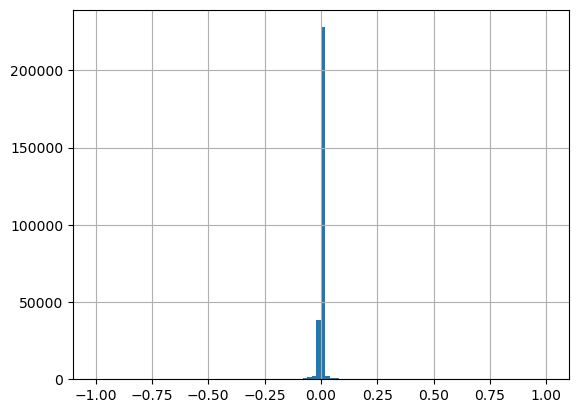

In [35]:
(df['prob'] - df['prob_without_penalty']).hist(bins=100)

# assignment test

In [2]:
from src import config 
config.load_config()

from src.utils import read_, read_all
from src.itinerary import filter_dis_file, cal_in_vehicle_penal_all, compute_itinerary_probabilities
from src.timetable import find_overload_train_section
from src.congest_penal import build_penal_mapper_df

left = read_(config.CONFIG["results"]["left"], show_timer=False)
assigned = read_all(config.CONFIG["results"]["assigned"], show_timer=False)
dis_df_from_file = read_(config.CONFIG["results"]["dis"], show_timer=False)

dis_attached_iti = filter_dis_file(dis_df_from_file=dis_df_from_file, left=left)

# this takes 10s
overload_train_section = find_overload_train_section(assigned=assigned)
penalized_iti = cal_in_vehicle_penal_all(
    penal_mapper_df=build_penal_mapper_df(
        overload_train_section=overload_train_section,
        penal_func_type="x",
        penal_agg_method="min"
    ),
    left=left
)

# this takes 10s
prob = compute_itinerary_probabilities(dis_attached_iti=dis_attached_iti, penalized_iti=penalized_iti)
prob

[INFO] Reading file: results\trajectory\left.pkl
[INFO] Reading 1 versioned files: results\trajectory\assigned.pkl
[INFO] Reading file: results\itinerary\dis.pkl
[INFO] Reading file: data\TT.pkl


dis  penalty    dis_penaled  dis_penaled_sum  \
rid     iti_id                                                           
285     1        1.398369e-98      1.0   1.398369e-98         8.820042   
        2        1.398369e-98      1.0   1.398369e-98         8.820042   
        3        1.398369e-98      1.0   1.398369e-98         8.820042   
        4        9.970899e-01      1.0   9.970899e-01         8.820042   
        5        1.398369e-98      1.0   1.398369e-98         8.820042   
...                       ...      ...            ...              ...   
2046865 2        2.987034e-01      1.0   2.987034e-01         0.298703   
2046868 1       1.943704e-101      1.0  1.943704e-101         0.358818   
        2        3.588177e-01      1.0   3.588177e-01         0.358818   
2046883 1        8.579250e-01      1.0   8.579250e-01         0.857925   
        2       2.105958e-101      1.0  2.105958e-101         0.857925   

                         prob  
rid     iti_id                 
285     1        1.585445e-99  
        2        1.585445e-99  
        3        1.585445e-99  
        4        1.130482e-01  
        5        1.585445e-99  
...                       ...  
2046865 2        1.000000e+00  
2046868 1       5.416968e-101  
        2        1.000000e+00  
2046883 1        1.000000e+00  
        2       2.454711e-101  

[16339032 rows x 5 columns]

In [5]:
data = prob.reset_index()[["rid", "iti_id", "prob"]].to_numpy()
data

array([[2.85000000e+002, 1.00000000e+000, 1.58544522e-099],
       [2.85000000e+002, 2.00000000e+000, 1.58544522e-099],
       [2.85000000e+002, 3.00000000e+000, 1.58544522e-099],
       ...,
       [2.04686800e+006, 2.00000000e+000, 1.00000000e+000],
       [2.04688300e+006, 1.00000000e+000, 1.00000000e+000],
       [2.04688300e+006, 2.00000000e+000, 2.45471147e-101]])

In [7]:
import numpy as np

sorted_idx = np.lexsort((-data[:, 2], data[:, 0]))  # -prob, rid
data_sorted = data[sorted_idx]
data_sorted

array([[2.85000000e+002, 4.00000000e+000, 1.13048210e-001],
       [2.85000000e+002, 2.20000000e+001, 6.98878264e-003],
       [2.85000000e+002, 3.00000000e+001, 6.98878264e-003],
       ...,
       [2.04686800e+006, 1.00000000e+000, 5.41696759e-101],
       [2.04688300e+006, 1.00000000e+000, 1.00000000e+000],
       [2.04688300e+006, 2.00000000e+000, 2.45471147e-101]])

In [14]:
import pandas as pd

unique_rids, first_idx = np.unique(data_sorted[:, 0], return_index=True)
data_result = data_sorted[first_idx]
most_probable_iti_df = pd.DataFrame(data_result, columns=["rid", 'iti_id', 'prob'])
most_probable_iti_df['rid'] = most_probable_iti_df['rid'].astype(int)
most_probable_iti_df['iti_id'] = most_probable_iti_df['iti_id'].astype(int)
most_probable_iti_df

,rid,iti_id,prob
0,285,4,0.113048
1,286,4,0.113048
2,287,1,1.000000
3,288,3,1.000000
4,296,14,0.071429
...,...,...,...
1195441,2046756,2,1.000000
1195442,2046837,1,1.000000
1195443,2046865,2,1.000000
1195444,2046868,2,1.000000


<Axes: >

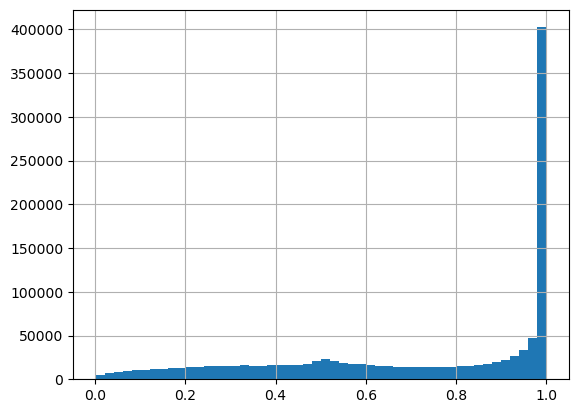

In [15]:
most_probable_iti_df['prob'].hist(bins=50)

# Multiple max_prob (<= 50%) for one rid: 44593 rids.

- this means that for the same egress walk times, multiple feasible itineraries of that rid have:
    - entry time > 500
    - transfer time > 500
    - which make those itineraries share the total 100% probability

In [27]:
### ✅ max-prob uniqueness check ###
from matplotlib.pyplot import flag


is_unique_max = np.ones(len(first_idx), dtype=bool)

prob_first = data_sorted[first_idx, 2]
# second max prob, potentially equal to max_prob
prob_next = data_sorted[first_idx + 1, 2]

is_unique_max = prob_first != prob_next  # check uniqueness

non_unique_rids = unique_rids[~is_unique_max]
print(f"Number of rid with non-unique max prob: {len(non_unique_rids)}")
print(f"Example rids: {non_unique_rids[:10]}")

flag_df = pd.DataFrame({
    'rid': unique_rids,
    'is_unique_max': is_unique_max,
    'prob': prob_first
})
flag_df = flag_df[~is_unique_max]
print(flag_df.rid.values)
flag_df

Number of rid with non-unique max prob: 44593
Example rids: [317. 319. 392. 433. 435. 438. 471. 473. 512. 573.]
[3.170000e+02 3.190000e+02 3.920000e+02 ... 2.044826e+06 2.045101e+06
 2.045110e+06]


,rid,is_unique_max,prob
7,317.0,False,0.010791
8,319.0,False,0.010791
15,392.0,False,0.035952
23,433.0,False,0.064104
24,435.0,False,0.039996
...,...,...,...
1195030,2044036.0,False,0.256929
1195033,2044046.0,False,0.256929
1195206,2044826.0,False,0.101363
1195273,2045101.0,False,0.500000


<Axes: >

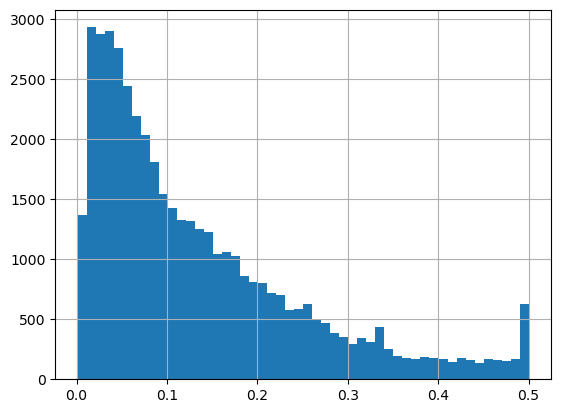

In [17]:
flag_df['prob'].hist(bins=50)

In [19]:
flag_df.sort_values(by=["prob"], ascending=False).head(20)

,rid,is_unique_max,prob
560096,935795.0,False,0.5
630576,1070069.0,False,0.5
24347,48997.0,False,0.5
429322,688339.0,False,0.5
698869,1199899.0,False,0.5
78881,136878.0,False,0.5
698897,1199959.0,False,0.5
467677,757387.0,False,0.5
455668,735442.0,False,0.5
467641,757322.0,False,0.5


In [31]:
prob[prob.index.get_level_values("rid").isin(flag_df.rid.values)]

dis  penalty    dis_penaled  dis_penaled_sum  \
rid     iti_id                                                           
317     1        4.890764e-01      1.0   4.890764e-01        45.321250   
        2        4.890769e-01      1.0   4.890769e-01        45.321250   
        3        4.890769e-01      1.0   4.890769e-01        45.321250   
        4        4.890769e-01      1.0   4.890769e-01        45.321250   
        5        4.890769e-01      1.0   4.890769e-01        45.321250   
...                       ...      ...            ...              ...   
2045110 9       7.447173e-100      1.0  7.447173e-100         4.324945   
        10       6.425232e-01      1.0   6.425232e-01         4.324945   
        11       5.987130e-01      1.0   5.987130e-01         4.324945   
        12       7.420919e-01      1.0   7.420919e-01         4.324945   
        13       6.038347e-99      1.0   6.038347e-99         4.324945   

                         prob  
rid     iti_id                 
317     1        1.079133e-02  
        2        1.079134e-02  
        3        1.079134e-02  
        4        1.079134e-02  
        5        1.079134e-02  
...                       ...  
2045110 9       1.721912e-100  
        10       1.485622e-01  
        11       1.384325e-01  
        12       1.715841e-01  
        13       1.396168e-99  

[5238804 rows x 5 columns]